# Pynbody Demo for Ramses simulation outputs

In [26]:
%matplotlib inline
import gc
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import pynbody
import pynbody.plot as pp
import pynbody.plot.sph
import pynbody.filt as filt
import pynbody.units as units
import pynbody.analysis.profile as profile

This notebook highlights some of the basic `pynbody` functionality to get you on the way to analyzing your own simulations. It doesn't assume any python knowledge, though familiarity with basic concepts of the language will certainly help. 

The `pynbody` webpage is [here]( http://pynbody.github.io/) and you can find the documentation with additional tutorials [here](http://pynbody.github.io/pynbody/). If you find that things are broken *please please please* let us know by submitting a [bug report on github](https://github.com/pynbody/pynbody/issues). If you want to run the notebook on your own machine, you need to point the `load` function below to whatever output you wish to use. 

In what follows, we demonstrate the usage of pynbody with Ramses simulation outputs. Support for this particular format is still under active development and although it is becoming increasingly robust, you may encounter strange behavior. 

In [28]:
mpl.rcParams['figure.figsize'] = (20,12)
mpl.rcParams['font.size'] = 18

## Data loading and exploration

loading a simulation output using the `pynbody.load()` function, which tries to automatically determine which type of code output you have.

Note that the `pynbody.ramses.multiprocess_num` and `pynbody.config['number_of_threads']` define how many threads the Ramses reader and the pynbody routines should use. Change these to match your system. 

In [2]:
import pynbody
pynbody.ramses.multiprocess_num = 12
pynbody.config['number_of_threads'] = 12
s = pynbody.load('output_00016')

/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/pynbody/snapshot/ramses.py:374: RuntimeWarning: RamsesSnap is configured to use multiple processes, but the posix_ipc module is missing. Reverting to single thread.
  warnings.warn("RamsesSnap is configured to use multiple processes, but the posix_ipc module is missing. Reverting to single thread.", RuntimeWarning)
/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/pynbody/snapshot/ramses.py:521: UserWarning: Using field 'tform' to distinguish stars. If this is wrong, try editing your config.ini, section [ramses], entry particle-distinguisher.
  warnings.warn("Using field %s to distinguish stars. If this is wrong, try editing your config.ini, section [ramses], entry particle-distinguisher."%pb_name)


A quick look at some basic information about the run we just opened: 

In [8]:
s

<SimSnap "output_00016" len=319647549>

In [9]:
len(s)

319647549

In [10]:
len(s.stars)

2310

`stars`, `gas`, `dark` also available as `s`, `g`, `d`

In [11]:
len(s.g), len(s.gas)

(185427511, 185427511)

The `properties` attribute of a `SimSnap` is a dictionary that tells us some more basic info about the simulation:

In [12]:
s.properties

{'a': 0.0588261160837484,
 'boxsize': Unit("7.66e+23 cm"),
 'h': 0.71,
 'omegaL0': 0.732999980449677,
 'omegaM0': 0.266999989748001,
 'time': Unit("2.53e-01 Gyr")}

In [13]:
s.properties['time'].in_units('Gyr')

0.253492910875594

In [14]:
# RS Add... Need to get the tform array
print (s.derivable_keys()[1:5])
pynbody.analysis.ramses_util.get_tform(s); # Don't need path...

['mass', 'temp', 'r_mag', 'i_mag']


In [15]:
s.properties['time'].in_units('Gyr')

0.253492910875594

## Accessing data

So far, we have only opened the simulation and read its metadata -- none of the actual cell or particle data has been read off the disk. To access any of these arrays or vectors, you access them like a python dictionary: 

which quantities do we have available?

In [16]:
s.keys()

[]

None! Because pynbody "lazy-loads" data... we need to try to access an array to read the data off the disk:

In [17]:
s['pos']

SimArray([[ 0.00212096,  0.06301872,  0.03071788],
       [ 0.03874487,  0.06407286,  0.02689162],
       [ 0.00113349,  0.02256903,  0.03036502],
       ..., 
       [ 0.98864746,  0.11413574,  0.09753418],
       [ 0.9876709 ,  0.11413574,  0.09753418],
       [ 0.98815918,  0.11413574,  0.09753418]], '7.66e+23 cm')

Note that each array is type `SimArray` (an extended `numpy` array) and has units attached.

In [18]:
s.keys()

['pos', 'vx', 'vy', 'y', 'x', 'vel', 'z', 'vz']

Note that not all particle families have the same arrays:

In [19]:
s.s.keys(), s.g.keys()

(['tform', 'pos', 'vx', 'vy', 'y', 'x', 'vel', 'z', 'vz'],
 ['pgf',
  'pzf',
  'p',
  'tv',
  'smooth',
  'metal',
  'pos',
  'vx',
  'rho',
  'vy',
  'y',
  'x',
  'vel',
  'z',
  'vz'])

In [20]:
s['mass'], s['vel']

(SimArray([  6.19486467e-09,   6.19486467e-09,   6.19486467e-09, ...,
          6.69146404e-11,   7.97209350e-11,   1.31498019e-10], '5.58e+45 g'),
 SimArray([[  2.33316546e-04,  -9.18588110e-05,  -3.87632894e-03],
        [  8.50341509e-04,   2.48981245e-05,  -4.36646942e-03],
        [  8.23279950e-05,  -1.25751643e-03,  -3.93386604e-03],
        ..., 
        [ -9.50491938e-05,   6.54826066e-04,  -2.83769503e-03],
        [  7.51937311e-04,   5.98799361e-04,  -2.73338140e-03],
        [  2.59880298e-04,   5.63238581e-04,  -2.70769283e-03]], '5.10e+08 cm s**-1'))

By default everything is in system units, but you can request an array in different units:

In [14]:
s['mass'].in_units('m_p'), s['vel'].in_units('Mpc yr^-1')

(SimArray([  1.40943029e+68,   1.40943029e+68,   1.40943029e+68, ...,
          3.49341602e+57,   3.26889323e+57,   3.35294151e+57], 'm_p'),
 SimArray([[  1.04855120e-10,  -3.02781894e-10,   3.05591523e-10],
        [ -5.09548653e-12,  -3.28728237e-10,   3.06589151e-10],
        [  2.50748181e-11,  -2.17715615e-10,   6.75479899e-11],
        ..., 
        [ -1.73985636e-10,  -1.99949828e-11,  -1.10899682e-10],
        [ -1.73988205e-10,  -2.21217356e-11,  -1.10960552e-10],
        [ -1.75131069e-10,  -2.02813170e-11,  -1.10814482e-10]], 'Mpc yr**-1'))

`in_units` produces a "view" of the array in the desired units, but the data is not altered in memory. You can permanently alter it with 

In [15]:
s['mass'].convert_units('m_p')
s['mass']

SimArray([  1.40943029e+68,   1.40943029e+68,   1.40943029e+68, ...,
         3.49341602e+57,   3.26889323e+57,   3.35294151e+57], 'm_p')

Or you can ask for everything to be converted to "physical" units (there is a similar convenience function to convert back to original units also):

In [16]:
s.physical_units()

SimSnap: converting pos units from 6.16e+26 cm to kpc
SimSnap: converting vel units from 1.41e+09 cm s**-1 to km s**-1
SimSnap: converting mass units from m_p to Msol
SimSnap: converting p units from 5.02e-12 g cm**-1 s**-2 to km**2 Msol s**-2 kpc**-3
SimSnap: converting smooth units from 6.16e+26 cm to kpc
SimSnap: converting rho units from 2.53e-30 g cm**-3 to Msol kpc**-3


We have defined many useful quantities that are automatically calculated for you. For example, the radial and tangential velocities are simply obtained by

In [17]:
s['vt'],s['vr']

SimSnap: deriving array vt
SimSnap: deriving array v2
SimSnap: deriving array vr
SimSnap: deriving array r


(SimArray([ 392.0037547 ,  435.51170488,  223.91531001, ...,  107.00691314,
         105.46517315,  107.53279984], 'km s**-1'),
 SimArray([ 183.81436575,   59.55845491,  -12.07430806, ..., -172.14401735,
        -173.37977902, -172.9047343 ], 'km s**-1'))

you can get a list of all available derivable quantities 

In [21]:
s.derivable_keys()[0:10]

['tform',
 'mass',
 'temp',
 'r_mag',
 'i_mag',
 'K_lum_den',
 'vtheta',
 'U_lum_den',
 'vcxy',
 'j2']

Defining your own derivable quantity requires a single decorator line and can be done inside any module that you import into your python session:

In [19]:
@pynbody.ramses.RamsesSnap.derived_quantity
def my_quantity(self) : 
    return self['x']*self['y']

In [20]:
s['my_quantity']

SimSnap: deriving array my_quantity


SimArray([  1.46194737e+07,   1.01377668e+08,   1.29737299e+08, ...,
         9.96316553e+09,   9.96339360e+09,   9.96324152e+09], 'kpc**2')

## Centering and aligning halos

The first thing you probably do after running a cosmological simulation is to run it through a halo finder like hop to get halo information. A few helper functions are defined in `pynbody.analysis.ramses_util` to load the halo data from a hop output and center the snapshot. Note that if hop data is not found, it will be automatically generated. Of course, if you are running this on your own machine, both hop and the script need to be in your path, or you must generate the data independently.

Hop output is in system units, so we need to convert back before centering:

In [22]:
#s.original_units()
pynbody.analysis.ramses_util.hop_center(s)

IOError: hop/grp00016.pos not found.

We've recentered the simulation on the most massive halo according to hop, but this usually isn't particularly accurate so we can redo the centering using a "shrinking sphere" method:

In [23]:
pynbody.analysis.halo.center(s[pynbody.filt.Sphere('100 kpc')],mode='ssc')

## Rendering images

Lets look at the dark matter distribution of a part of the whole simulation box. Note that we can specify the desired units here as well -- by specifying a unit of surface density, we tell pynbody to render a projection:

SimArray([[ 141276.421875 ,  141447.390625 ,  141618.78125  , ...,
         168329.390625 ,  168537.765625 ,  168751.25     ],
       [ 141498.328125 ,  141630.296875 ,  141762.640625 , ...,
         168588.203125 ,  167749.484375 ,  166911.953125 ],
       [ 141720.046875 ,  141813.15625  ,  141906.5      , ...,
         168850.1875   ,  166960.375    ,  165071.796875 ],
       ..., 
       [ 126128.328125 ,  126061.9765625,  125995.5859375, ...,
         197491.4375   ,  196849.03125  ,  196213.328125 ],
       [ 126064.5703125,  125932.625    ,  125800.609375 , ...,
         196606.59375  ,  196307.6875   ,  196011.84375  ],
       [ 126000.8046875,  125803.2421875,  125605.484375 , ...,
         195569.4375   ,  195683.34375  ,  195788.75     ]], dtype=float32, 'Msol kpc**-2')

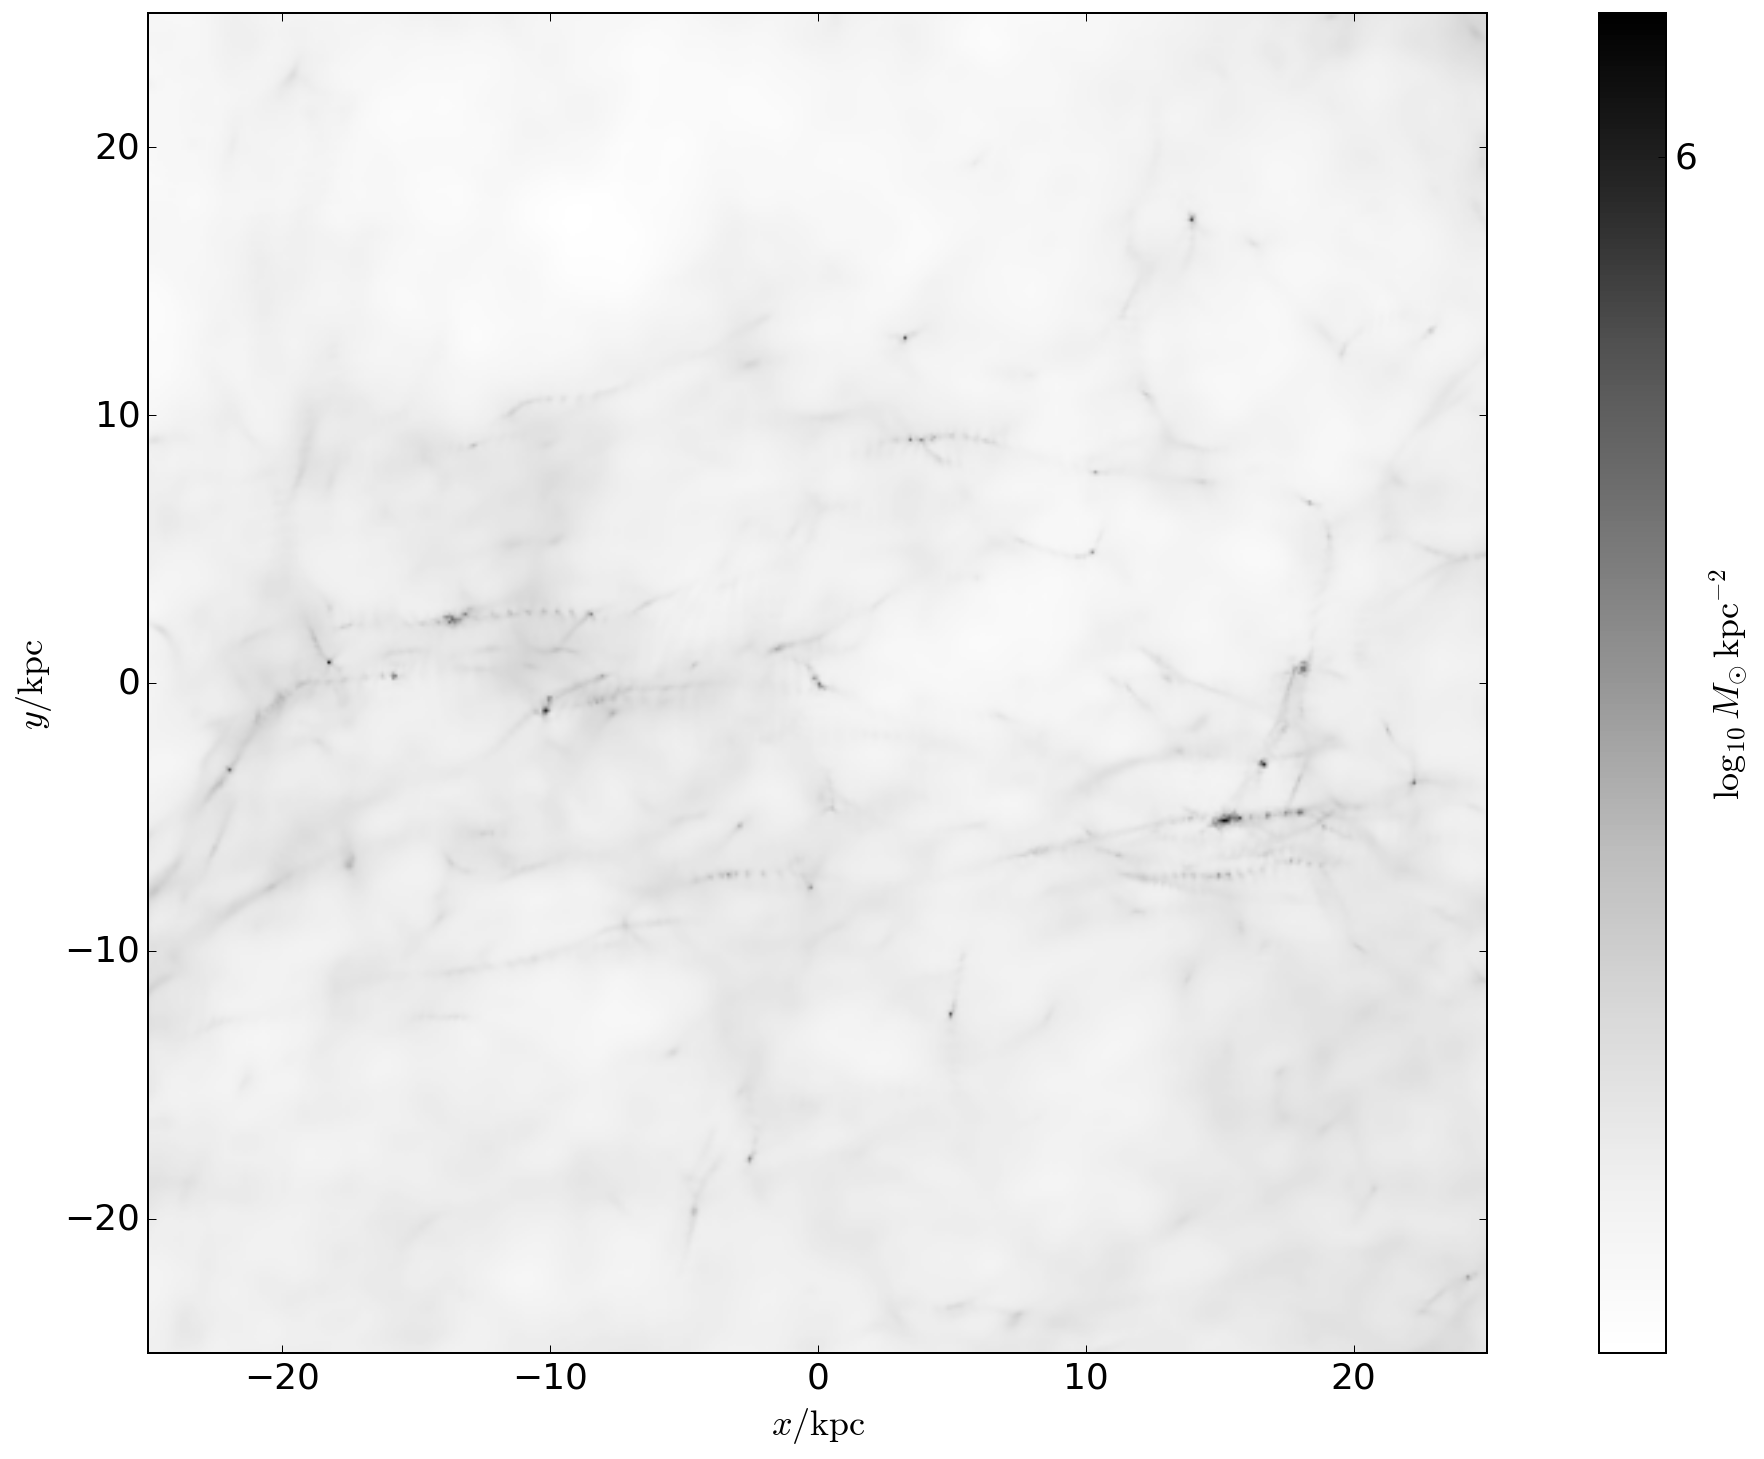

In [29]:
s.physical_units();
pynbody.plot.image(s.d,width='50 kpc', units='Msol kpc^-2', cmap=mpl.cm.Greys)

Now that we are centered on the main halo, we can cut out a region of roughly the virial radius: 

In [30]:
sph = pynbody.filt.Sphere('80 kpc')
h1 = s[sph]
h1

<SimSnap "output_00016:sphere" len=50556070>

This new object is a `SubSnap` of the full simulation, and behaves in exactly the same way:

In [31]:
len(h1.d), len(h1.s), len(h1.g)

(20951654, 249, 29604167)

In [32]:
h1['mass'].sum().in_units('1e12 Msol')

SimArray(0.43774320648589327, '1.00e+12 Msol')

Typically we want to make sure the system is aligned in some predictable way, so pynbody allows us to make the disk angular momentum axis the z-axis:

In [33]:
pynbody.analysis.angmom.faceon(h1,cen=(0,0,0),disk_size='5 kpc')

we use `cen=(0,0,0)` because we have already centered it in the previous step... if you don't specify a center, `faceon` centers the snapshot before aligning. The `disk_size` keyword specifies the region which is used for calculating the angular momentum vector. Now lets look at a slice of the gas disk edge-on: 

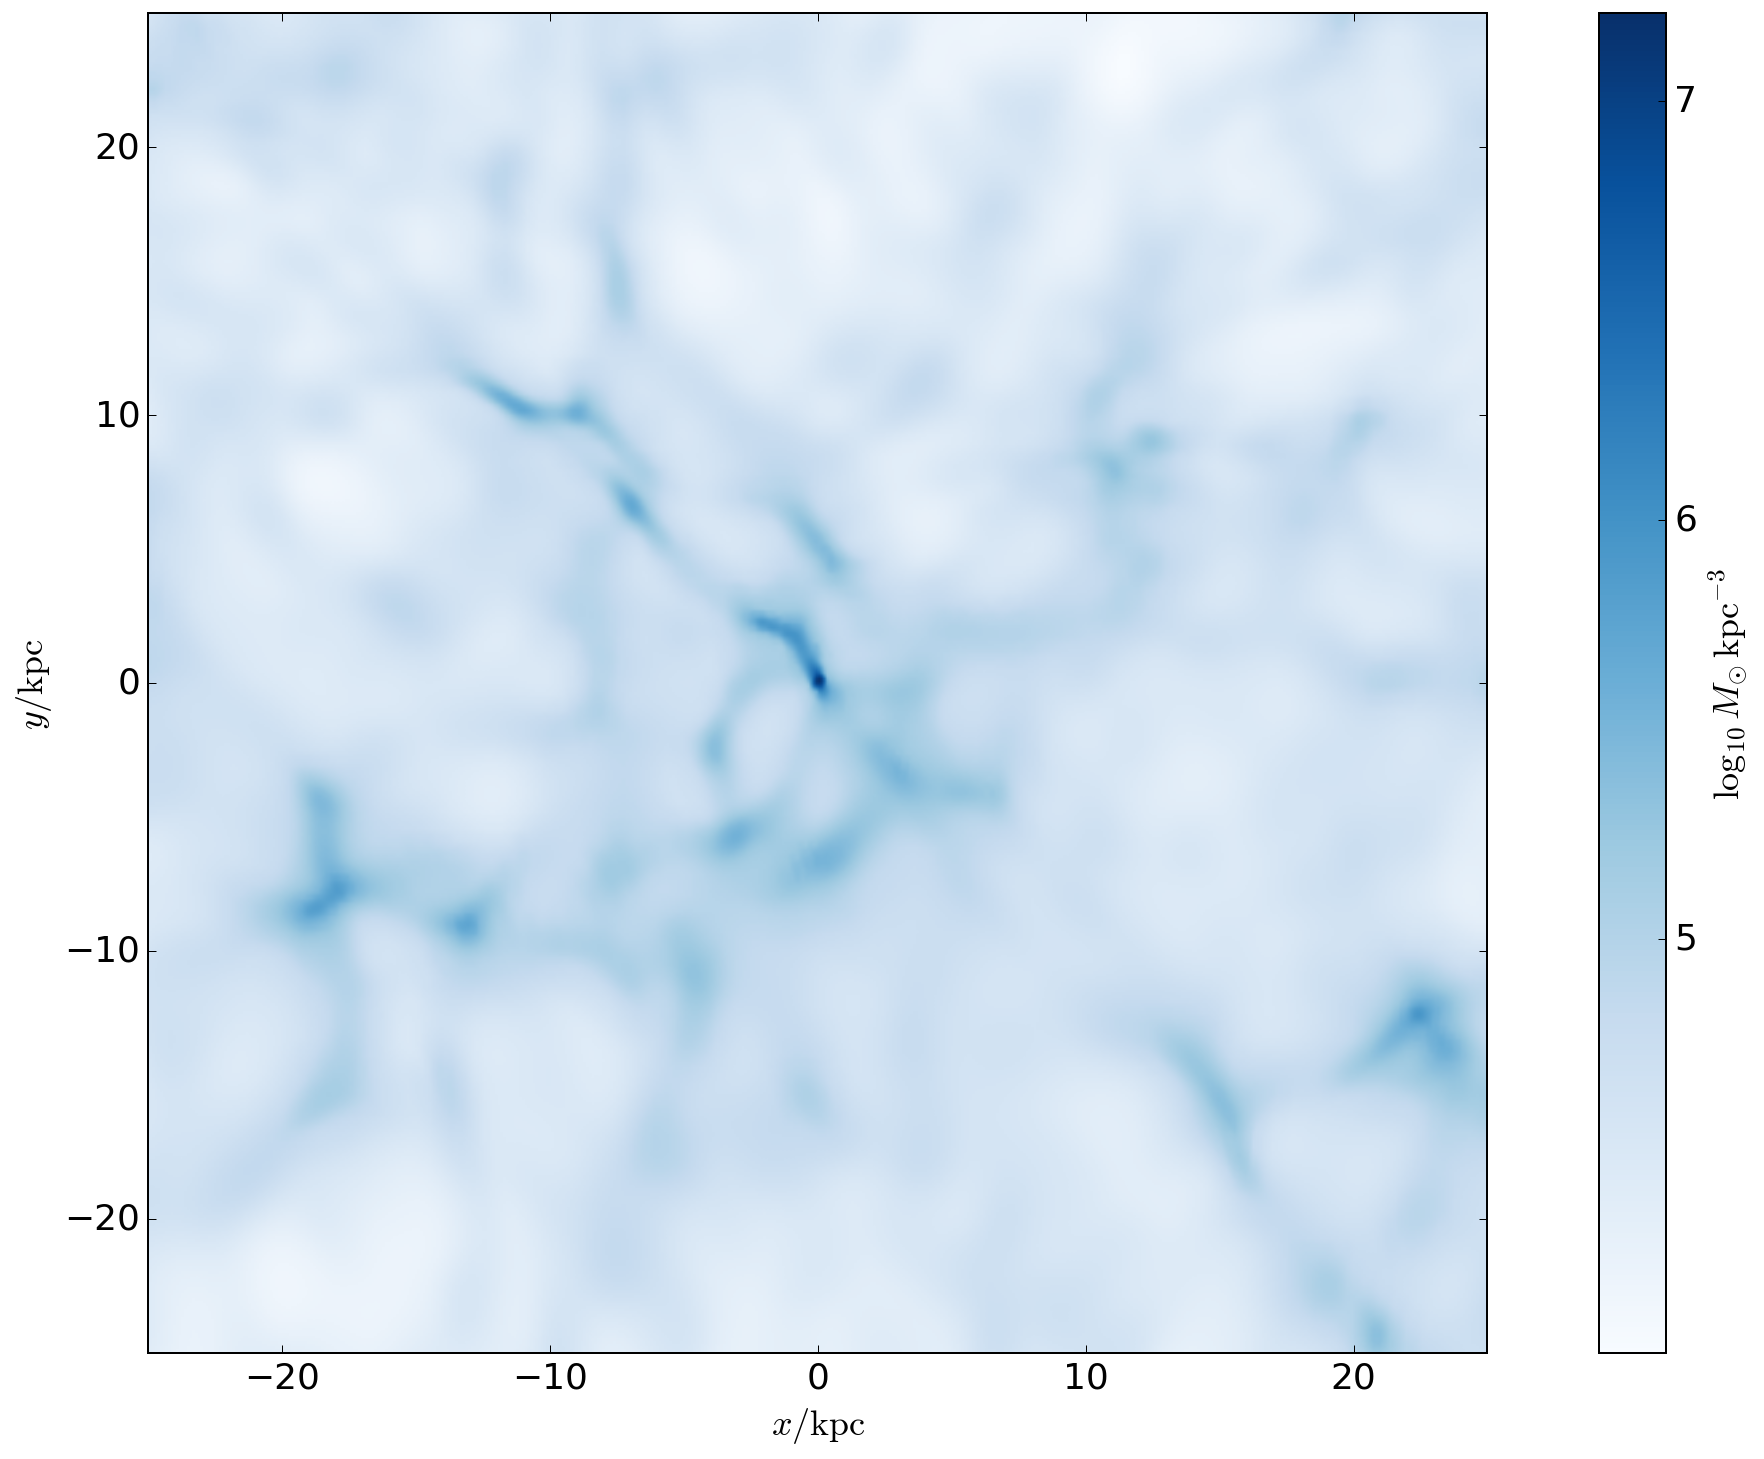

In [35]:
s.rotate_x(90)
pynbody.plot.image(s.g,width='50 kpc',denoise=True, cmap=mpl.cm.Blues);

By default, `rho` (i.e. density) is used to render the image, but *any* valid array is fair game:

In [36]:
pynbody.plot.image(s.g,qty='temp',width='50 kpc',denoise=True, cmap=mpl.cm.YlOrRd)
s.rotate_x(-90)

KeyboardInterrupt: 

You can also make projections of weighted quantities:

SimSnap: deriving array vr
SimSnap: deriving array

Rendering image on 16 threads...
Rendering image on 16 threads...
Rendering image on 16 threads...
Rendering image on 16 threads...


 r


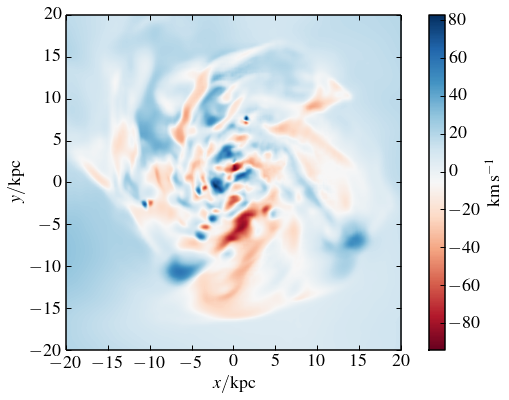

In [30]:
pynbody.plot.image(s.g,qty='vr',width='40 kpc',denoise=True,av_z='rho',log=False, cmap=mpl.cm.RdBu);

## Profiles

`pynbody` includes a `Profile` class that implements some basic functionality for creating (you guessed it) profiles. For a more detailed description of its functionality head over to the [Profile documentation](http://link).

To start with, lets create a 3D spherical profile of the total matter distribution using log-spaced bins, and additional profiles for the stars and gas:

Profile: density()
Profile: mass()
Profile: density()
Profile: mass()
Profile: density()
Profile: mass()


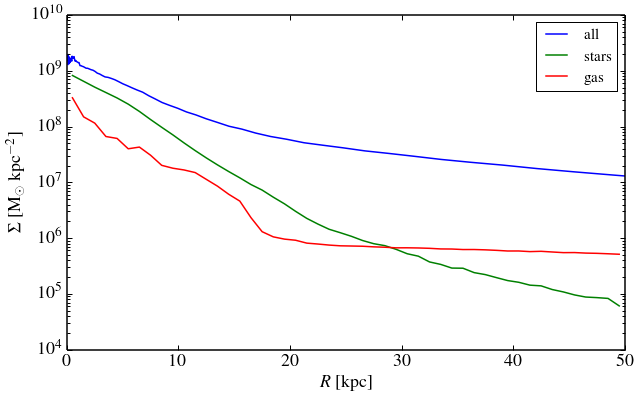

In [31]:
p = pynbody.analysis.profile.Profile(h1,max='200 kpc',min='.1 kpc',type='log',nbins=100)
ps = pynbody.analysis.profile.Profile(h1.s,max='50 kpc',nbins=50)
pg = pynbody.analysis.profile.Profile(h1.g,max='50 kpc',nbins=50)
plot(p['rbins'], p['density'], label = 'all')
plot(ps['rbins'], ps['density'], label = 'stars')
plot(pg['rbins'], pg['density'], label = 'gas')
semilogy()
xlim(0,50)
legend()
xlabel('$R$ [kpc]')
ylabel('$\Sigma$ [M$_{\odot}$ kpc$^{-2}$]')

The `Profile` class has lots of built-in functionality:

In [32]:
p.derivable_keys()

['j_theta',
 'v_circ',
 'E_circ',
 'kappa',
 'density',
 'mass_enc',
 'pot',
 'magnitudes',
 'Q',
 'beta',
 'jtot',
 'mass',
 'j_circ',
 'X',
 'dyntime',
 'g_spherical',
 'sb',
 'fourier',
 'omega',
 'rotation_curve_spherical',
 'j_phi']

Profile: v_circ() -- warning, disk must be in the x-y plane
Rotation curve calculated in  10.3 s
Profile: v_circ() -- warning, disk must be in the x-y plane
Rotation curve calculated in  2.61 s
Profile: v_circ() -- warning, disk must be in the x-y plane
Rotation curve calculated in  3.81 s


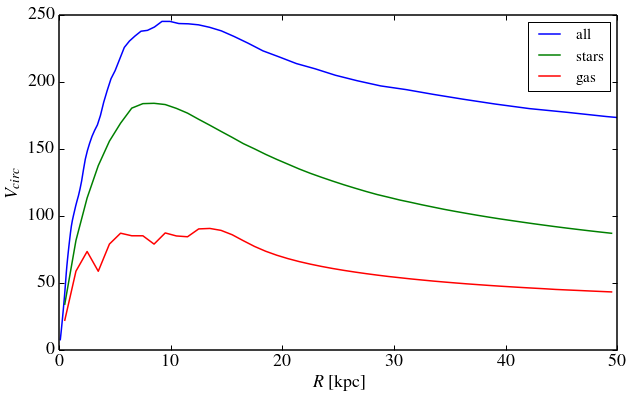

In [33]:
s['eps']=s.g['smooth'].min()
plot(p['rbins'], p['v_circ'], label = 'all')
plot(ps['rbins'], ps['v_circ'], label = 'stars')
plot(pg['rbins'], pg['v_circ'], label = 'gas')
xlim(0,50)
xlabel('$R$ [kpc]')
ylabel('$V_{circ}$')
legend()

In addition, `Profile` can use *any* loaded (or loadable/derivable!) array. If the data is not in-memory already, it will be lazy-loaded or calculated:

SimSnap: deriving array vr
SimSnap: deriving array r


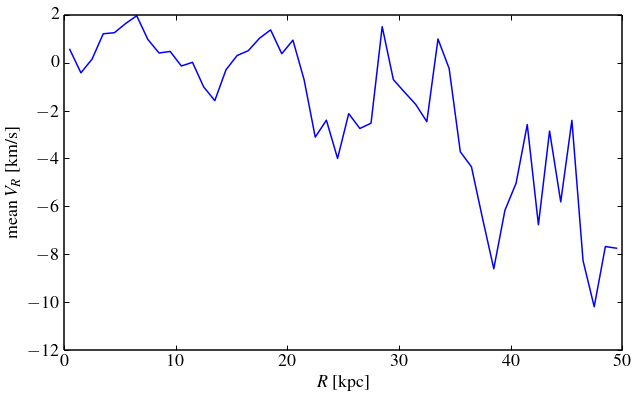

In [34]:
plot(ps['rbins'],ps['vr'])
xlabel('$R$ [kpc]')
ylabel('mean $V_R$ [km/s]')

By default, `Profile` calculates the means of quantities, but it trivially calculate derivatives, dispersions, and root-mean-square values as well: 

Profile: d_v_circ/dR


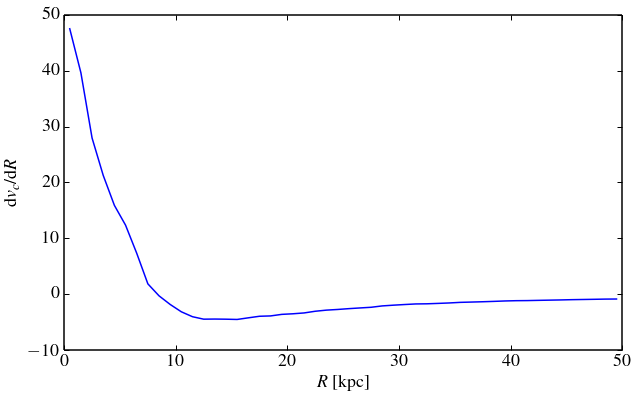

In [35]:
plot(ps['rbins'],ps['d_v_circ'])
xlabel('$R$ [kpc]')
ylabel('d$v_{c}$/d$R$')

Profile: auto-deriving vr_rms


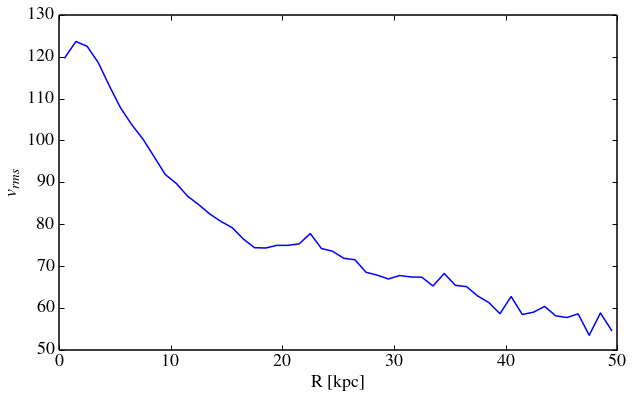

In [36]:
plot(ps['rbins'],ps['vr_rms'])
xlabel('R [kpc]')
ylabel('$v_{rms}$')

## Filters

You can define filters to select particles based on their quantities. Under the hood, this just calls the `numpy.where` function, but it makes your code much more readable. For example, to get stars that are 1-2 Gyr old:

In [37]:
metfilt = pynbody.filt.BandPass('metal', 1e-3,1e-2)
metfilt

BandPass('metal', 1.00e-03, 1.00e-02)

In [38]:
disc = pynbody.filt.Disc('20 kpc', '1 kpc')
h1[disc].s

<SimSnap "/zbox/data/roskar/cosmo/AMR/rad_fbk/std/output_00101:sphere:disc::star" len=574050>

In [39]:
h1.s[disc]['mass'].sum().in_units('1e10 Msol')

SimArray(4.18613882677458, '1.00e+10 Msol')

you can combine filters by using simple logic operators -- so to get the total mass of all 1-2 Gyr old stars within 50 kpc, you can do

In [40]:
h1.s[disc&metfilt]['mass'].sum().in_units('1e10 Msol')

SimArray(0.47000260266959104, '1.00e+10 Msol')

#Converting to other formats

Often it's desirable to convert a Ramses output into some other format for post processing (running other halo finders, for example). This is quite easily achieved with pynbody, but the unit conversion can be tricky -- so we've created a few helper functions in `pynbody.analysis.ramses_util` to make this less painful: 

In [41]:
pynbody.analysis.ramses_util.convert_to_tipsy_fullbox(s.filename)

Loading using backend <class 'pynbody.ramses.RamsesSnap'>
RamsesSnap: loading hydro files done
SimSnap: deriving array 1 3 5 7 9 11 13 15 17 19 21 23 25 29 31 27 2 4 6 8 10 12 14 16 18 20 22 24 26 30 32 28 63 61 39 53 43 37 41 33 35 45 47 55 49 59 57 51 64 62 40 54 44 38 42 34 36 46 48 56 50 60 58 52 95 93 83 81 79 71 85 65 67 73 75 69 77 89 87 91 96 94 84 82 80 72 86 66 68 74 76 70 78 90 88 92 127 121 113 117 109 103 115 97 99 105 107 101 111 123 119 125 128 122 114 118 110 104 116 98 100 106 108 102 112 124 120 126 temp
TipsySnap: writing main file as /zbox/data/roskar/cosmo/AMR/rad_fbk/std/output_00101_fullbox.tipsy
TipsySnap: writing auxiliary arrays


This also creates a .param file with requisite units information in order to inform pynbody about the units system. 

If you don't want the full box for some reason (e.g. to speed up analysis) and only want to save a part of the simulation for quick-and-dirty post processing, you can do this with another function: 

In [43]:
pynbody.analysis.ramses_util.convert_to_tipsy_simple(s.filename,pynbody.filt.Sphere('200 kpc'))

Loading using backend <class 'pynbody.ramses.RamsesSnap'>
RamsesSnap: loading hydro files

Finding halo velocity center...
vcen= [ 0.00016491 -0.00013521 -0.00032374]
Calculating angular momentum vector...
Transforming simulation...

 done
SimSnap: deriving array 1 3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 63 59 39 51 43 37 41 33 35 45 47 55 49 53 61 57 64 60 40 52 44 38 42 34 36 46 48 56 50 54 62 58 95 87 75 89 81 69 79 65 67 73 77 71 83 85 91 93 96 88 76 90 82 70 80 66 68 74 78 72 84 86 92 94 127 117 113 121 119 101 105 97 99 109 111 103 107 115 125 123 128 118 114 122 120 102 106 98 100 110 112 104 108 116 126 124


[   2213.59814674    2996.23889034    1685.19782238 ...,  268515.38612534
  261518.35324757  261736.69514807]

 temp
SimSnap: deriving array temp
TipsySnap: writing main file as output_00101.tipsy
RamsesSnap: loading grav files done
TipsySnap: writing auxiliary arrays 1 3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 63 59 43 49 39 37 41 33 35 45 47 57 53 51 61 55 64 60 44 50 40 38 42 34 36 46 48 58 54 52 62 56 95 87 73 81 77 69 85 65 67 79 75 89 83 91 93 71 96 88 74 82 78 70 86 66 68 80 76 90 84 92 94 72 127 117 111 115 113 101 119 97 99 105 109 123 107 125 121 103 128 118 112 116 114 102 120 98 100 106 110 124 108 126 122 104

The newly-generated output in tipsy format can now be used in the same way as the RAMSES output: 

In [44]:
stipsy = pynbody.load('/zbox/data/roskar/cosmo/AMR/rad_fbk/std/output_00101_fullbox.tipsy')

Loading using backend <class 'pynbody.tipsy.TipsySnap'>
TipsySnap: loading  /zbox/data/roskar/cosmo/AMR/rad_fbk/std/output_00101_fullbox.tipsy


In [45]:
stipsy

<SimSnap "/zbox/data/roskar/cosmo/AMR/rad_fbk/std/output_00101_fullbox.tipsy" len=23196808>

In [46]:
len(stipsy.s),len(stipsy.g)

(1243472, 14817745)

In [47]:
stipsy.properties

{'a': 1.00001844594404,
 'boxsize': Unit("2.00e+05 kpc a"),
 'h': 0.703969087746729,
 'omegaL0': 0.728,
 'omegaM0': 0.272,
 'time': Unit("1.41e+01 s kpc km**-1")}

We have previously generated an Amiga Halo Finder halo catalogue for this snapshot -- so now we can load the halos and use the halo catalogue framework: 

In [48]:
h = stipsy.halos()

AHFCatalogue: loading particles... halos... substructure... done!


In [49]:
pynbody.analysis.halo.center(h[1],mode='ssc')

Finding halo velocity center...
vcen= [-0.02096087 -0.0040748  -0.01705168]


TipsySnap: loading data from main file


SimSnap: deriving array rho
Building 16 trees with leafsize=16
Tree build done in  5.05 s
Calculating SPH density
SimSnap: deriving array smooth
Smoothing with 32 nearest neighbours
Smoothing done in  3.98s
Density calculation done in  1.89 s

Rendering image on 16 threads...


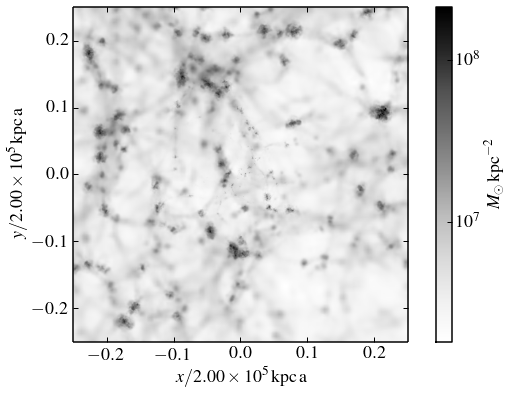

In [50]:
pynbody.plot.image(stipsy.d,width='100 Mpc',units='Msol kpc^-2',cmap=cm.Greys);